[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/03-structured-outputs-function-calling-tools.ipynb)

# Part 3: Structured Outputs, Function Calling & Native Tools

This section covers three powerful capabilities of the Gemini API: structured outputs for extracting information into defined schemas, function calling for connecting to external tools and APIs, and native tools like Google Search for enhanced capabilities.

In [2]:
from google import genai
from google.genai import types
from pydantic import BaseModel
from typing import List, Optional
import sys
import os
from IPython.display import Image, Markdown

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import userdata
    GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
else:
    GEMINI_API_KEY = os.environ.get('GOOGLE_API_KEY',None)

# Create client with api key
MODEL_ID = "gemini-2.5-flash-preview-05-20"
client = genai.Client(api_key=GEMINI_API_KEY)

## 1. Structured Outputs

Structured outputs allow you to constrain Gemini to respond with JSON in a specific format instead of unstructured text. This is essential for:
- **Data extraction**: Converting unstructured text into structured data
- **API integration**: Getting consistent formats for downstream processing  
- **Database insertion**: Ensuring data matches your schema requirements
- **Quality control**: Validating that responses contain required fields

In [ ]:
class Recipe(BaseModel):
    recipe_name: str
    ingredients: List[str]
    prep_time_minutes: int
    difficulty: str  # "easy", "medium", "hard"
    servings: int

class RecipeList(BaseModel):
    recipes: List[Recipe]

# Using Pydantic models for structured output
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Give me 2 popular cookie recipes with ingredients and prep details.",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=RecipeList,
    ),
)

# Get structured data directly
recipes: List[Recipe] = response.parsed
for recipe in recipes.recipes:
    print(f"Recipe: {recipe.recipe_name}")
    print(f"Ingredients: {recipe.ingredients}")
    print(f"Prep Time: {recipe.prep_time_minutes} minutes")
    print(f"Difficulty: {recipe.difficulty}")
    print(f"Servings: {recipe.servings}")
    print("\n")

Recipe: Classic Chocolate Chip Cookies
Ingredients: ['1 1/2 cups all-purpose flour', '1 teaspoon baking soda', '1/2 teaspoon salt', '1 cup (2 sticks) unsalted butter, softened', '1/2 cup granulated sugar', '1 cup packed light brown sugar', '2 large eggs', '1 teaspoon vanilla extract', '2 cups chocolate chips']
Prep Time: 20 minutes
Difficulty: Easy
Servings: 24


Recipe: Chewy Oatmeal Raisin Cookies
Ingredients: ['1 1/2 cups all-purpose flour', '1 teaspoon baking soda', '1 teaspoon ground cinnamon', '1/2 teaspoon salt', '1 cup (2 sticks) unsalted butter, softened', '1/2 cup granulated sugar', '1 cup packed light brown sugar', '2 large eggs', '1 teaspoon vanilla extract', '3 cups old-fashioned rolled oats', '1 1/2 cups raisins']
Prep Time: 20 minutes
Difficulty: Easy
Servings: 24




## !! Exercise: PDF to Structured Data !!

Extract structured information from a PDF invoice or document using the Files API and structured outputs.

Tasks:
- A Pydantic schema (`InvoiceItem` and `InvoiceData`) and an example PDF file path (`../assets/data/rewe_invoice.pdf`) are provided. You can use this or replace it with your own PDF invoice.
- Upload the PDF file using `client.files.upload()`.
- Call `client.models.generate_content()`:
- Access the parsed structured data from `response.parsed`.

In [ ]:
class InvoiceItem(BaseModel):
    item: str
    quantity: int
    unit_price: float
    size: str
    total: float

class InvoiceData(BaseModel):
    invoice_number: str
    date: str
    vendor_name: str
    vendor_address: str
    total_amount: float
    items: List[InvoiceItem]

# Upload a PDF file (replace with your PDF path)
pdf_file_path = "/content/IMG_0283.jpeg"

# TODO:
#file_id = client.files.upload(file=pdf_file_path)
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Give me all relevent information from the photo. If the information is not available put nan.",
    config=types.GenerateContentConfig(

        response_schema=InvoiceData,
    ),
)


## 2. Function Calling

Function calling allows Gemini to intelligently decide when to call specific functions you define. This enables:
- **External API integration**: Connect to weather, stocks, databases
- **Dynamic calculations**: Perform real-time computations
- **System interaction**: Execute commands or retrieve system information
- **Multi-step workflows**: Chain function calls for complex tasks

In [ ]:
def get_weather(location: str) -> dict:
    """Gets current weather for a location.

    Args:
        location: The city name, e.g. "San Francisco"

    Returns:
        Weather information dictionary
    """
    # Mock weather data - in real use, you'd call a weather API
    weather_data = {
        "temperature": 22,
        "condition": "sunny",
        "humidity": 60,
        "location": location,
        "feels_like": 24
    }
    print(f"🌤️ FUNCTION CALLED: get_weather(location='{location}')")
    return weather_data

# Define function declarations for the model
weather_function = {
    "name": "get_weather",
    "description": "Gets current weather for a location",
    "parameters": {
        "type": "object",
        "properties": {
            "location": {
                "type": "string",
                "description": "The city name"
            }
        },
        "required": ["location"]
    }
}
tools = [types.Tool(function_declarations=[weather_function])]

# Define user prompt
contents = [
    types.Content(
        role="user", parts=[types.Part(text="Whats the weather in Tokyo?")]
    )
]


# Send request with function declarations
response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(tools=tools)
)

# Check for function calls
function_call = response.candidates[0].content.parts[0].function_call
print(f"Model wants to call: {function_call.name}")
print(f"With arguments: {dict(function_call.args)}")

In [ ]:
# Execute the function
if function_call.name == "get_weather":
    result = get_weather(**function_call.args)
else:
    result = {"error": "Unknown function"}

print(f"Function result: {result}")

# Send function result back to model
function_response_part = types.Part.from_function_response(
    name=function_call.name,
    response={"result": result}
)
# Append function call and result of the function execution to contents
contents.append(types.Content(role="model", parts=[types.Part(function_call=function_call)])) # Append the model's function call message
contents.append(types.Content(role="user", parts=[function_response_part])) # Append the function response

# Get final response
final_response = client.models.generate_content(
    model=MODEL_ID,
    contents=contents,
    config=types.GenerateContentConfig(tools=tools)
)

print(f"\nFinal response: {final_response.text}")

### Automatic Function Calling (Python Only)

The Python SDK can automatically handle function execution for you:

In [ ]:
def calculate_area(length: float, width: float) -> dict:
    """Calculate the area of a rectangle.

    Args:
        length: Length of the rectangle
        width: Width of the rectangle

    Returns:
        Price calculations
    """
    area = length * width
    print(f"CALC: {length} × {width} = {area}")
    return {"operation": "area", "result": area}

# Using automatic function calling - much simpler!
config = types.GenerateContentConfig(
    tools=[get_weather, calculate_area]  # Pass functions directly
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the weather in Tokyo and what's the area of a 5x3 meter room?",
    config=config
)

print(response.text)  # SDK handles function calls automatically

## !! Exercise: Calculator Agent !!

Create a set of calculator functions (add, subtract, multiply, divide) and use Gemini's function calling capability to perform calculations based on natural language prompts.

Tasks:
- Define Python functions for `add(a: float, b: float)`, `subtract(a: float, b: float)`, `multiply(a: float, b: float)`, and `divide(a: float, b: float)`.
- Create a list of these functions (`calculator_tools`).
- Test single operations with `client.models.generate_content()`:
- Test complex expressions with a prompt for a multi-step calculation (e.g., "Calculate (25 + 15) * 3 - 10. Do this step by step.").

In [ ]:
# TODO:
def add(a:float, b:float) -> dict:
  sum = a + b
  print(f"CALC: {a} + {b} = {sum}")
  return {"operation": "sum", "result": sum}

def subtract(a:float, b:float) -> dict:
  difference = a - b
  print(f"CALC: {a} - {b} = {difference}")
  return {"operation": "subtraction", "result": difference}

config = types.GenerateContentConfig(
    tools=[add, subtract]  # Pass functions directly
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="what is the difference of 5 and 2",
    config=config
)

print(response.text)  # SDK handles function calls automatically

CALC: 5 - 2 = 3


The difference between 5 and 2 is 3.


## 3. Native Tools

Gemini provides native tools for enhanced capabilities like searching the web and analyzing URL content.

### Google Search Integration

**Use cases:**
- Current events and news
- Real-time data lookup
- Fact verification
- Research assistance

In [ ]:
# Define Google Search tool
google_search_tool = types.Tool(google_search=types.GoogleSearch())

# Current events query
response = client.models.generate_content(
    model=MODEL_ID,
    contents="What are the latest developments in renewable energy technology in 2025?",
    config=types.GenerateContentConfig(
        tools=[google_search_tool],
    )
)

print("🔍 Current Renewable Energy News:")
print(response.text)

### URL Context Tool

**Use cases:**
- Website content analysis
- Documentation summarization
- Competitive research
- Content extraction

In [ ]:
# URL context for analyzing specific web pages
url_context_tool = types.Tool(url_context=types.UrlContext())

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Summarize the key features and benefits mentioned on https://www.python.org/about/ in 3 bullet points.",
    config=types.GenerateContentConfig(
        tools=[url_context_tool],
    )
)

print("🌐 Python.org Summary:")
print(response.text)

### Code Execution Tool

Gemini can execute Python code to perform calculations, create visualizations, and process data.

To create the bar chart, I first need to gather the population data for the 5 largest cities in the world. Population figures can vary based on the source and the definition of "city" (e.g., city proper, urban area, metropolitan area). For this chart, I will use widely cited estimates for urban area populations as of recent years.

Here are the 5 largest cities by urban area population and their approximate figures (in millions):

1.  **Tokyo, Japan:** ~37.2 million
2.  **Delhi, India:** ~32.9 million
3.  **Shanghai, China:** ~29.2 million
4.  **Dhaka, Bangladesh:** ~23.2 million
5.  **São Paulo, Brazil:** ~22.6 million

Now, I will use `matplotlib` to create the bar chart.



```python
import matplotlib.pyplot as plt

# Data for the 5 largest cities
cities = ['Tokyo', 'Delhi', 'Shanghai', 'Dhaka', 'São Paulo']
populations = [37.2, 32.9, 29.2, 23.2, 22.6] # in millions

# Create the bar chart
plt.figure(figsize=(10, 6)) # Set figure size for better readability
plt.bar(cities, populations, color='skyblue')

# Add titles and labels
plt.xlabel('City')
plt.ylabel('Population (Millions)')
plt.title('Population of the 5 Largest Cities in the World (Urban Area)')
plt.ylim(0, 40) # Set y-axis limit for better visualization

# Add value labels on top of the bars
for i, pop in enumerate(populations):
    plt.text(i, pop + 0.5, f'{pop:.1f}', ha='center', va='bottom')

# Display the plot
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for better readability
plt.show()
```

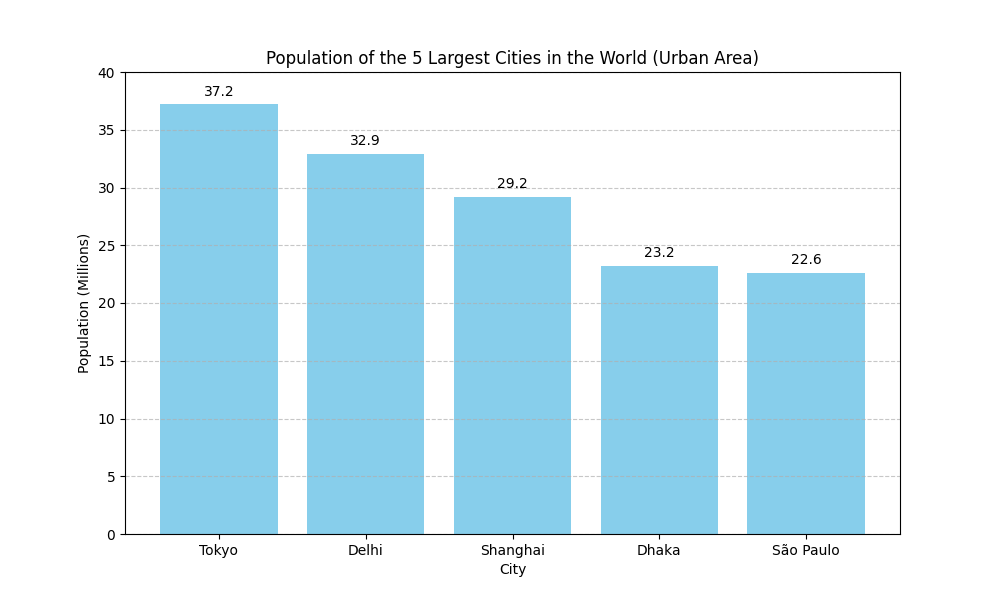

The image showing the bar chart of the population of the 5 largest cities in the world has been successfully generated and is available as `output_2025-07-15-19-20-27-205499.png`.

Do you have any further requests or modifications for this chart, or would you like to move on to a new task?

In [ ]:
# Code execution tool
code_execution_tool = types.Tool(code_execution={})

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Create a bar chart showing the population of the 5 largest cities in the world. Use matplotlib.",
    config=types.GenerateContentConfig(
        tools=[code_execution_tool],
    )
)


for p in response.candidates[0].content.parts:
    if p.text:
        display(Markdown(p.text))
    elif p.executable_code:
        display(Markdown(f"```python\n{p.executable_code.code}\n```"))
    elif p.inline_data:
        display(Image(data=p.inline_data.data, width=800, format="png"))


## !! Exercise: Data Analysis with Code Execution !!

Combine Google Search and Code Execution tools to find real-world data and then analyze or visualize it using Python code generated and executed by Gemini.

Tasks:
- Define a prompt that requires both searching for information and then processing/visualizing that information. For example: "Search for the population of the 5 largest cities in the world and create a bar chart of their populations."
- Create a `types.Tool` for code execution: `code_execution_tool = types.Tool(code_execution={})`.
- Create a `types.Tool` for Google Search: `google_search_tool = types.Tool(google_search=types.GoogleSearch())`.
- Call `client.models.generate_content()`:
- Iterate through the `response.candidates[0].content.parts` and display the parts.

```python
concise_search("top 10 VC funded companies 2024")

```

Here are the top VC-funded companies identified from 2024. Please note that comprehensive data for 2025 is not yet available, as the year is still ongoing, and funding information typically becomes public later. The list focuses on 2024, where several significant funding rounds occurred, primarily driven by investments in Artificial Intelligence.

Based on the search results, here are 9 companies that secured the largest VC fundings in 2024 (summing up multiple rounds for a single company within the year):

1.  **xAI**: $12.0 billion (May 2024, December 2024)
2.  **Databricks**: $10.0 billion (December 2024)
3.  **Vantage Data Center**: $9.2 billion (January 2024, June 2024)
4.  **Anthropic**: $6.75 billion (March 2024, November 2024)
5.  **OpenAI**: $6.6 billion (October 2024)
6.  **G42**: $1.5 billion (April 2024)
7.  **Anduril Industries**: $1.5 billion (August 2024)
8.  **CoreWeave**: $1.1 billion (May 2024)
9.  **Xaira Therapeutics**: $1.0 billion (April 2024)

Now, I will create a bar chart to visualize this data.



```python
import matplotlib.pyplot as plt
import pandas as pd

companies_data = [
    {"name": "xAI", "date": "May & Dec 2024", "funding_billion": 12.0},
    {"name": "Databricks", "date": "Dec 2024", "funding_billion": 10.0},
    {"name": "Vantage Data Center", "date": "Jan & June 2024", "funding_billion": 9.2},
    {"name": "Anthropic", "date": "Mar & Nov 2024", "funding_billion": 6.75},
    {"name": "OpenAI", "date": "Oct 2024", "funding_billion": 6.6},
    {"name": "G42", "date": "Apr 2024", "funding_billion": 1.5},
    {"name": "Anduril Industries", "date": "Aug 2024", "funding_billion": 1.5},
    {"name": "CoreWeave", "date": "May 2024", "funding_billion": 1.1},
    {"name": "Xaira Therapeutics", "date": "Apr 2024", "funding_billion": 1.0},
]

df = pd.DataFrame(companies_data)

# Sort by funding for better visualization
df = df.sort_values(by="funding_billion", ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.bar(df["name"], df["funding_billion"], color='skyblue')
plt.xlabel("Company Name")
plt.ylabel("Funding (Billion USD)")
plt.title("Top VC Funded Companies in 2024 (by total funding)")
plt.xticks(rotation=45, ha="right") # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add funding labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'${yval:.1f}B', ha='center', va='bottom')

plt.tight_layout()
plt.show()
```

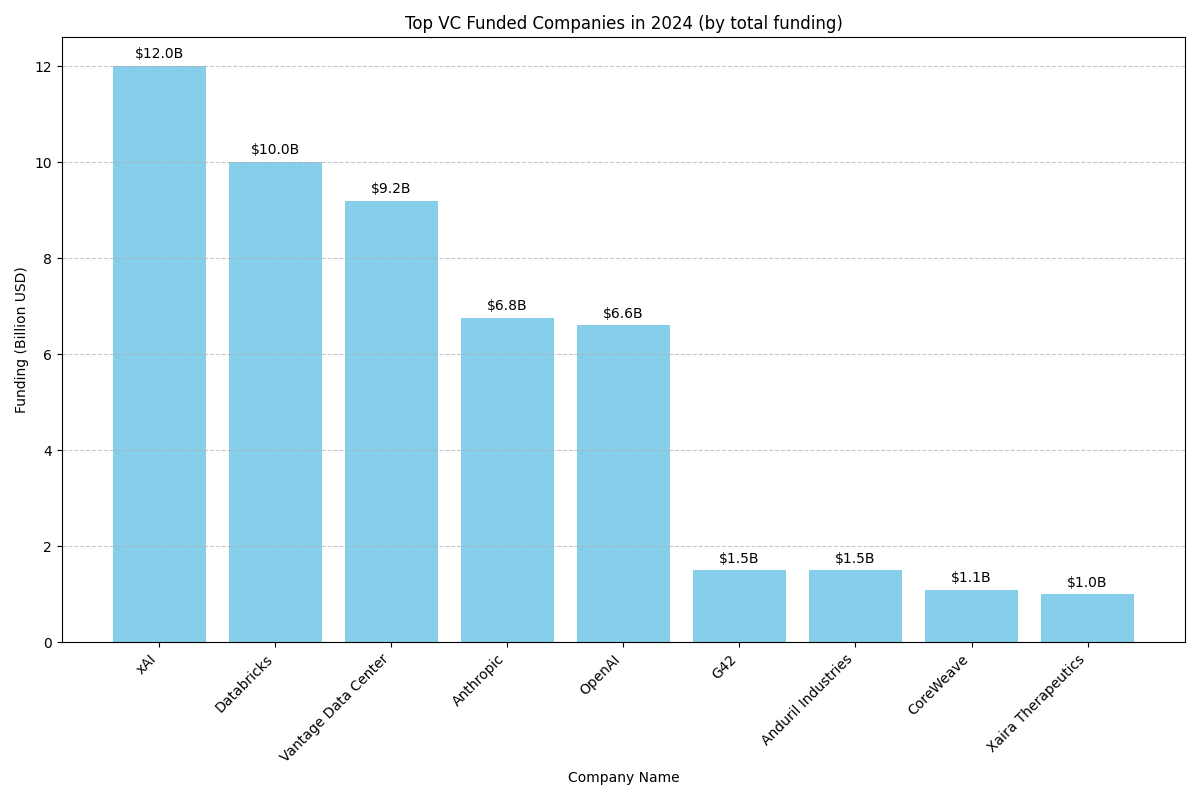

The bar chart above displays the top VC-funded companies in 2024, based on the total funding they secured. As comprehensive data for 2025 is not yet available, the chart focuses on the significant funding rounds observed in 2024.

**Top VC Funded Companies in 2024 (by total funding):**

*   **xAI:** $12.0 billion (May & December 2024)
*   **Databricks:** $10.0 billion (December 2024)
*   **Vantage Data Center:** $9.2 billion (January & June 2024)
*   **Anthropic:** $6.75 billion (March & November 2024)
*   **OpenAI:** $6.6 billion (October 2024)
*   **G42:** $1.5 billion (April 2024)
*   **Anduril Industries:** $1.5 billion (August 2024)
*   **CoreWeave:** $1.1 billion (May 2024)
*   **Xaira Therapeutics:** $1.0 billion (April 2024)

In [ ]:
# TODO:
# Define Google Search tool
google_search_tool = types.Tool(google_search=types.GoogleSearch())
code_execution_tool = types.Tool(code_execution={})

# Current events query
response = client.models.generate_content(
    model=MODEL_ID,
    contents="What the top 10 VC funded companies from 2024-2025? Gather the name, date and funding. Create a bar chart showing the 10 VC funded companies from 2024-2025. Use matplotlib",
    config=types.GenerateContentConfig(
        tools=[google_search_tool,code_execution_tool ],
    )
)


for p in response.candidates[0].content.parts:
    if p.text:
        display(Markdown(p.text))
    elif p.executable_code:
        display(Markdown(f"```python\n{p.executable_code.code}\n```"))
    elif p.inline_data:
        display(Image(data=p.inline_data.data, width=800, format="png"))

In [1]:
%pip install gitingest



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459.8 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.5/950.5 kB 43.9 MB/s eta 0:00:00


In [4]:
from gitingest import ingest_async

summary, tree, content = await ingest_async("https://github.com/rashedulkabir730/ETL-Complaints-Violations")

In [5]:
prompt = f"""Explain this project as if you were in a data analyst interview. Go through the entire porject process end to end. :

Code:
{content}
"""

chat = client.chats.create(model=MODEL_ID)

response = chat.send_message(prompt)
print(response.text)

"Good morning! I'm excited to share details about my ETL Complaints and Violations project. This project was born out of a common challenge: a pre-existing Streamlit web application that struggled with performance due to directly processing large datasets on the fly. My goal was to significantly improve the application's responsiveness and build a robust, automated data pipeline to ensure data quality and freshness.

Let me walk you through the entire process, end-to-end:

### 1. Problem Statement & Project Goal

The core problem was the **performance bottleneck** in an existing Streamlit application. It was pulling large datasets from NYC Open Data APIs directly, leading to slow load times and a poor user experience. As a data professional, I immediately recognized the need for a more structured data engineering approach to manage, transform, and serve this data efficiently.

My objective was to **enhance the application's performance** by implementing data engineering best practices.

## Recap & Next Steps

**What You've Learned:**
- Structured outputs using Pydantic models for reliable data extraction and validation
- Function calling to integrate external APIs, databases, and custom business logic
- Native tools including Google Search, URL context analysis, and code execution
- Combining multiple tools for comprehensive workflows and complex problem-solving

**Key Takeaways:**
- Structured outputs ensure consistent data formats for downstream applications
- Function calling enables seamless integration with external systems and real-time data
- Native tools provide powerful capabilities without additional setup or infrastructure
- Tool combinations unlock sophisticated workflows and multi-step problem solving
- Proper validation and error handling are crucial for reliable tool interactions

**Next Steps:** Continue with [Part 4: Model Context Protocol (MCP)](https://github.com/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/04-model-context-protocol-mcp.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/philschmid/gemini-2.5-ai-engineering-workshop/blob/main/notebooks/04-model-context-protocol-mcp.ipynb)

**More Resources:**
- [Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python)
- [Function Calling Documentation](https://ai.google.dev/gemini-api/docs/function-calling?lang=python)
- [Grounding with Google Search](https://ai.google.dev/gemini-api/docs/grounding)
- [URL Context Tool](https://ai.google.dev/gemini-api/docs/url-context)
- [Code Execution Documentation](https://ai.google.dev/gemini-api/docs/code-execution)